In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import pairplot
from dsn.util.dsn_util import get_system_from_template
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [2]:
sysname = 'V1Circuit'
behavior_type = "ISN_coeff"
param_dict = {'behavior_type':behavior_type,
              'silenced':'S'}
system = get_system_from_template(sysname, param_dict)

ISN_coeff


In [84]:
np.random.seed(0)
M = 200000

min_W = 0.0
max_W = 20.0
W_XE = np.random.uniform(0.0, max_W, (M,))

W_EP = np.random.uniform(0.0, max_W, (M,))
W_PP = np.random.uniform(0.0, max_W, (M,))
W_VP = np.random.uniform(0.0, max_W, (M,))
W_ES = np.random.uniform(0.0, max_W, (M,))
W_PS = np.random.uniform(0.0, max_W, (M,))
W_VS = np.random.uniform(0.0, max_W, (M,))
W_SV = np.random.uniform(0.0, max_W, (M,))

_Z = np.stack((W_XE, W_EP, W_PP, W_VP, W_ES, W_PS, W_VS, W_SV), axis=1)
_Z = np.expand_dims(_Z, 0)


In [85]:

num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z)
r_t = system.simulate(Z)

In [86]:

_T_x, _r_t = sess.run([T_x, r_t], {Z:_Z});


In [87]:
r_T_E = _r_t[-1,0,:,0,0]
r_T_P = _r_t[-1,0,:,1,0]
r_T_S = _r_t[-1,0,:,2,0]
r_T_V = _r_t[-1,0,:,3,0]

drdt_T = _r_t[-1,0,:,:,0] - _r_t[-2,0,:,:,0]

drdt_th = 0.001
on_th = 0.01

stable = np.prod(np.abs(drdt_T) < drdt_th, axis=1)
E_on = r_T_E > on_th
S_off = r_T_S < on_th
V_off = r_T_V < on_th

print('stable %d / %d' % (np.sum(stable), stable.shape[0]))
E_on_stable = np.logical_and(E_on, stable)

gamma = _T_x[0,:,0]
gamma_low = -5.0
gamma_high = -0.1
ISN_thresh = np.logical_and(gamma_low < gamma, gamma < gamma_high)

E_on_stable = np.logical_and(E_on_stable, ISN_thresh)

stable 188585 / 200000


In [88]:
t = np.linspace(0.0, system.dt*(system.T-1), system.T)
black = 'k'
red =  [0.8, 0.0, 0.0]
blue = [0.0, 0.0, 0.8]
green = [0.0, 0.8, 0.0]

In [89]:
plot_traces = False
if (plot_traces):
    r_ss_E = np.zeros((M,))
    for i in range(M):
        if (E_on_stable[i]):
            plt.figure()
            print(drdt_T[i,:])
            plt.plot(t, _r_t[:,0,i,0,0], '-', c=black)
            plt.plot(t, _r_t[:,0,i,1,0], '--', c=blue)
            plt.plot(t, _r_t[:,0,i,2,0],'-',  c=red)
            plt.plot(t, _r_t[:,0,i,3,0], '--', c=green)
            plt.legend(['E', 'P', 'S', 'V'])
            plt.xlabel('time')
            plt.ylabel('r(t)')
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.show()

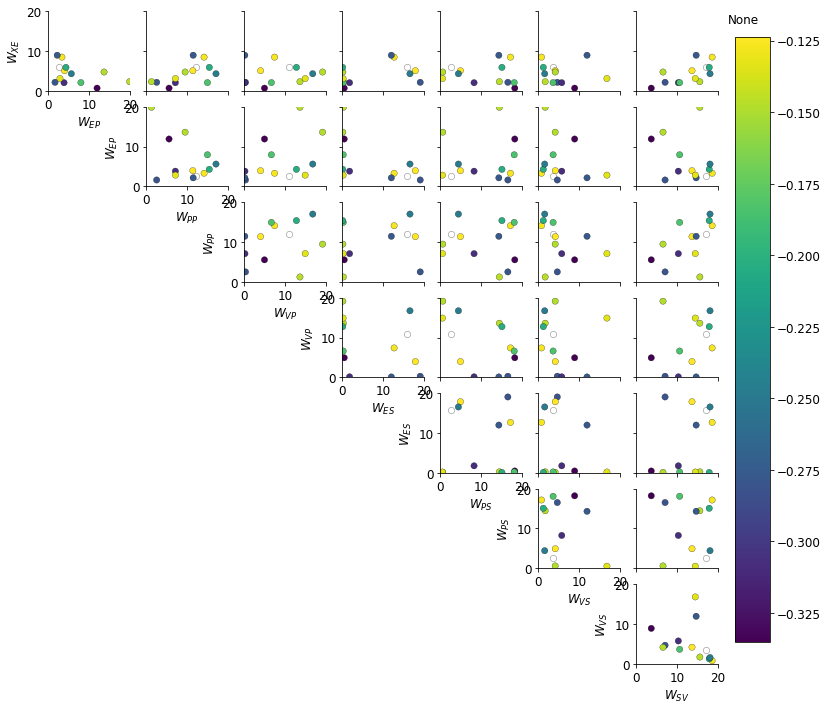

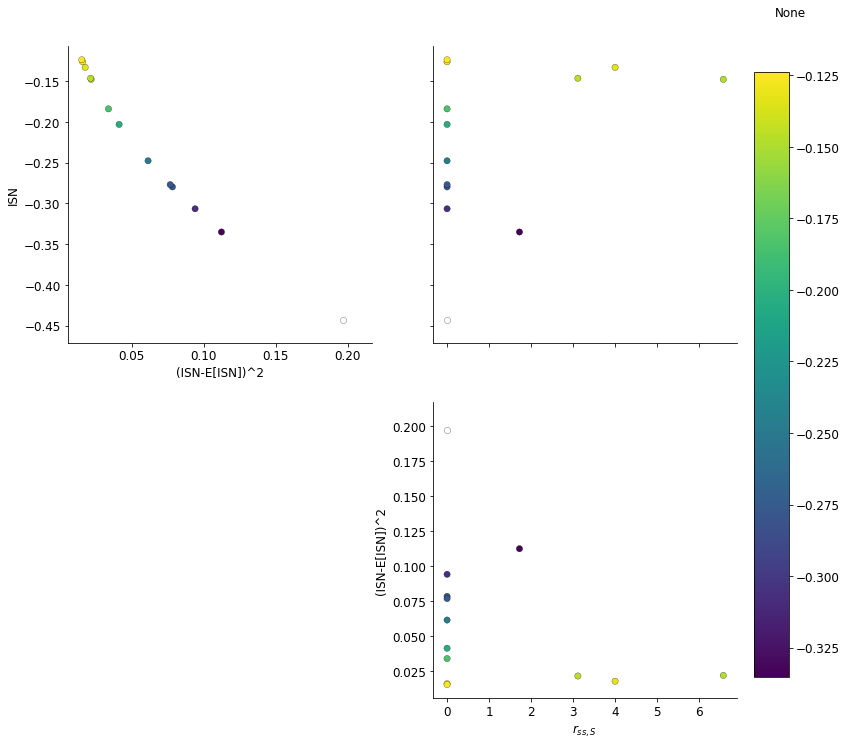

In [83]:
fig = pairplot(_Z[0,E_on_stable], range(8), system.z_labels, 
               c=_T_x[0,E_on_stable,0], xlims=[0, 20], ylims=[0, 20.0])
fig = pairplot(_T_x[0,E_on_stable], range(3), system.T_x_labels, 
               c=_T_x[0,E_on_stable,0])

In [90]:
E_on_S_off_stable = np.logical_and(S_off, E_on_stable)

Z_s_low = _Z[0, E_on_S_off_stable]
Z_s_low_mean = np.mean(Z_s_low, axis=0)
Z_s_low_std = np.std(Z_s_low, axis=0)

np.savez('data/V1/ISN_S_gauss_init.npz', mean=Z_s_low_mean, std=0.1*Z_s_low_std)

print('mean')
print(Z_s_low_mean)
print('std')
print(Z_s_low_std)

Z_s_low_mean = np.expand_dims(np.expand_dims(Z_s_low_mean, 0), 0)
Z_s_low_std = np.expand_dims(np.expand_dims(Z_s_low_std, 0), 0)


mean
[ 4.90941546  4.54183436 12.16549808  4.83655139  9.77084905 10.21355115
  4.87601454 14.17983625]
std
[3.49901558 2.8661482  4.69363504 3.87039741 5.66508146 5.71928485
 3.92567468 4.40656408]


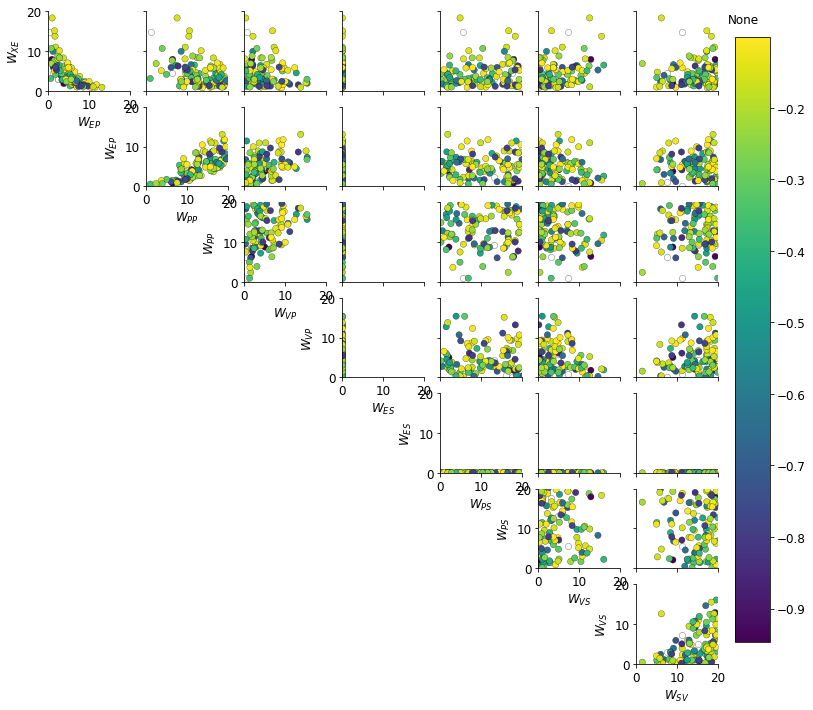

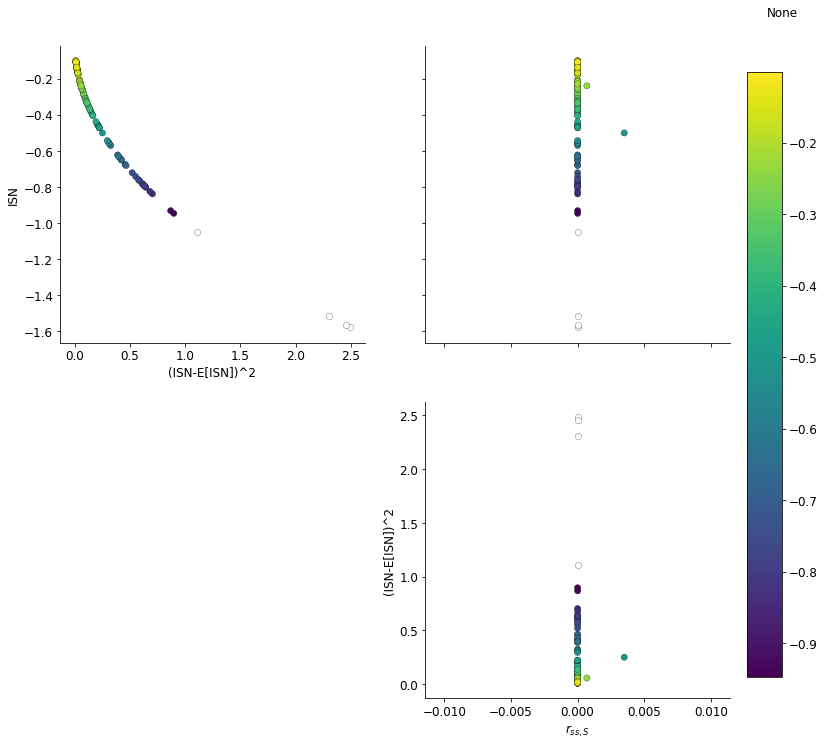

In [61]:
fig = pairplot(_Z[0,E_on_S_off_stable], range(8), system.z_labels, 
               c=_T_x[0,E_on_S_off_stable,0], xlims=[0, 20], ylims=[0, 20.0])

fig = pairplot(_T_x[0,E_on_S_off_stable], range(3), system.T_x_labels, 
               c=_T_x[0,E_on_S_off_stable,0])

num stable 1000 1000


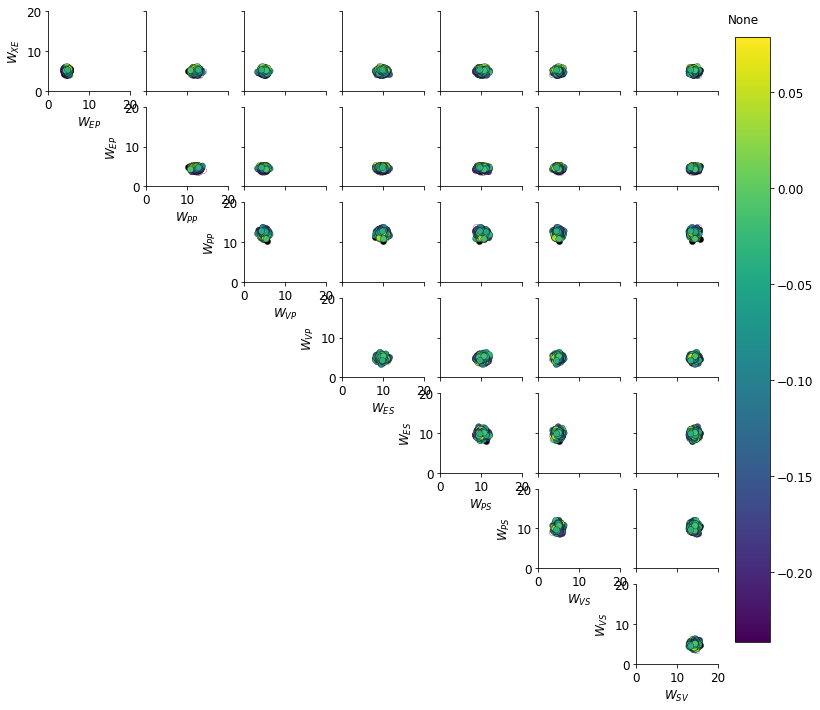

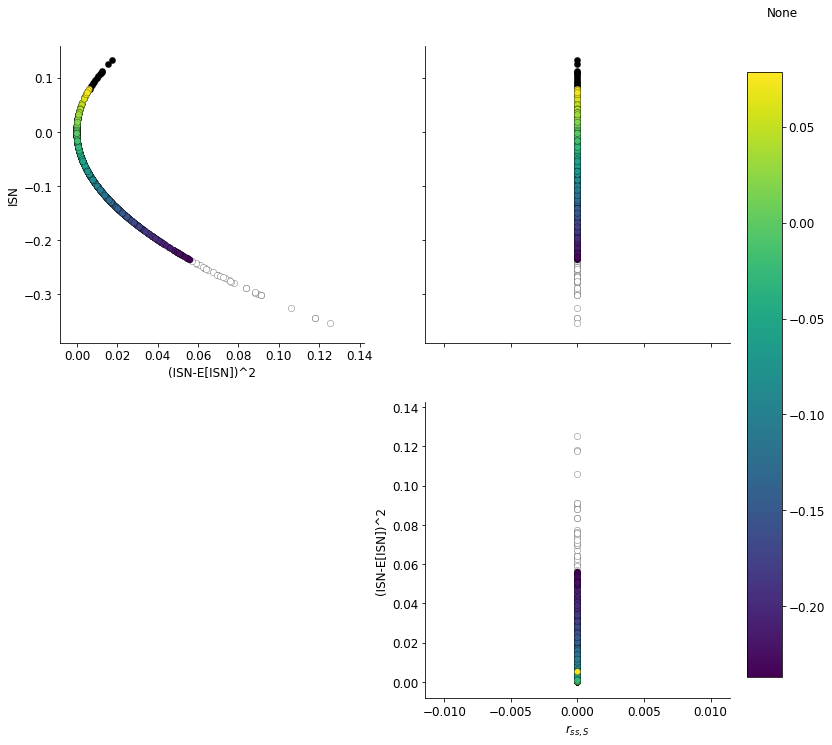

In [91]:
M = 1000
scale = 0.1*Z_s_low_std
_Z_s_low = np.random.normal(0.0, 1.0, (1,M,system.D))
_Z_s_low = (_Z_s_low * scale) + Z_s_low_mean
_T_x_s_low, _r_t_s_low = sess.run([T_x, r_t] , {Z:_Z_s_low});

drdt_T_s_low = _r_t_s_low[-1,0,:,:,0] - _r_t_s_low[-2,0,:,:,0]

stable_s_low = np.prod(np.abs(drdt_T_s_low) < drdt_th, axis=1).astype(bool)
print('num stable', np.sum(stable_s_low), M)


fig = pairplot(_Z_s_low[0,stable_s_low,:], range(8), system.z_labels, 
               c=_T_x_s_low[0,stable_s_low,0], xlims=[0.0, 20.0], ylims=[0.0, 20.0])

fig = pairplot(_T_x_s_low[0,stable_s_low], range(3), system.T_x_labels, 
               c=_T_x_s_low[0,stable_s_low,0])


In [92]:
mean_T_x_s_low = np.mean(_T_x_s_low[0], 0)
print(mean_T_x_s_low)

mean_T_x_s_low_stable = np.mean(_T_x_s_low[0,stable_s_low], 0)
print(mean_T_x_s_low_stable)

[-7.98135539e-02  1.26721367e-02  1.82492427e-11]
[-7.98135539e-02  1.26721367e-02  1.82492427e-11]


In [93]:
E_on_V_off_stable = np.logical_and(V_off, E_on_stable)


Z_v_low = _Z[0, E_on_V_off_stable]
Z_v_low_mean = np.mean(Z_v_low, axis=0)
Z_v_low_std = np.std(Z_v_low, axis=0)

np.savez('data/V1/ISN_V_gauss_init.npz', mean=Z_v_low_mean, std=0.1*Z_v_low_std)

Z_v_low_mean = np.expand_dims(np.expand_dims(Z_v_low_mean, 0), 0)
Z_v_low_std = np.expand_dims(np.expand_dims(Z_v_low_std, 0), 0)

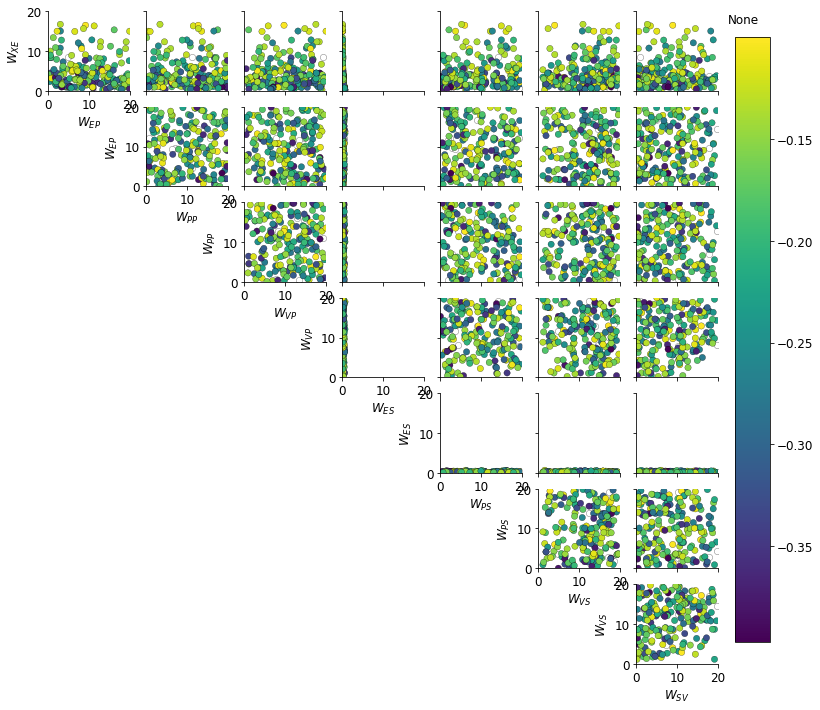

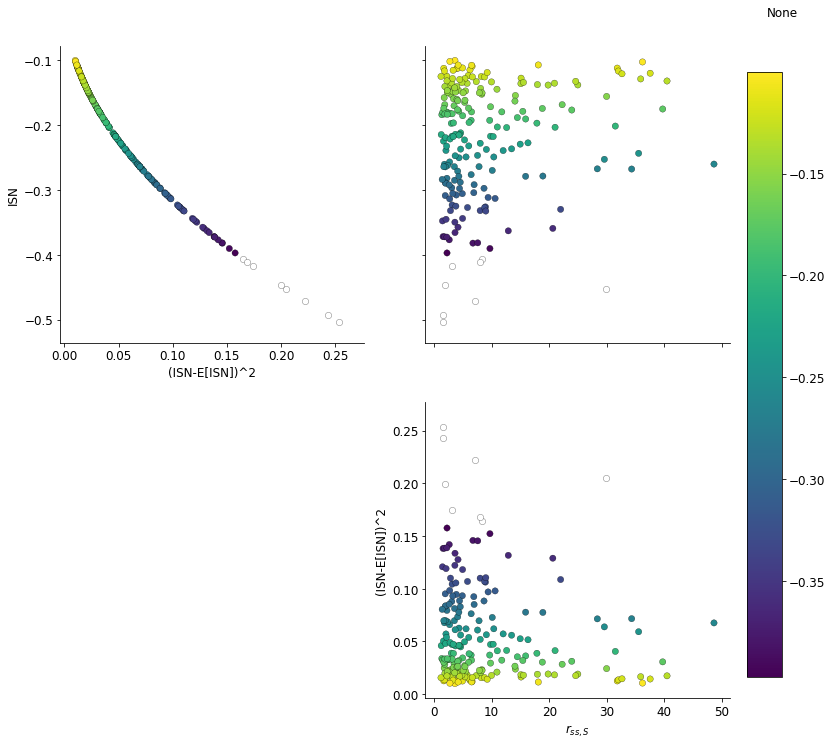

In [94]:
fig = pairplot(_Z[0,E_on_V_off_stable], range(8), system.z_labels, 
               c=_T_x[0,E_on_V_off_stable,0], xlims=[0, 20], ylims=[0, 20.0])

fig = pairplot(_T_x[0,E_on_V_off_stable], range(3), system.T_x_labels, 
               c=_T_x[0,E_on_V_off_stable,0])

num stable 573 1000


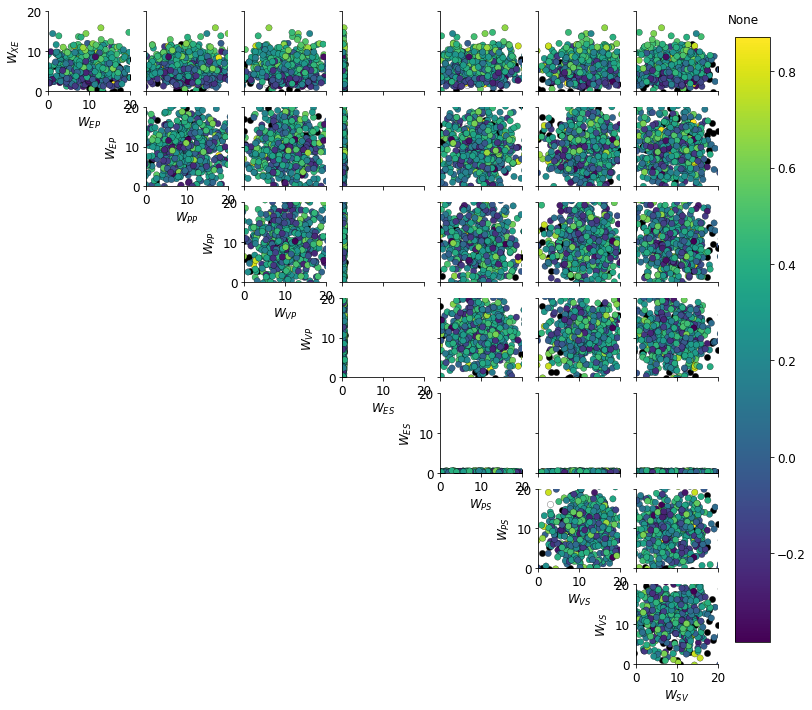

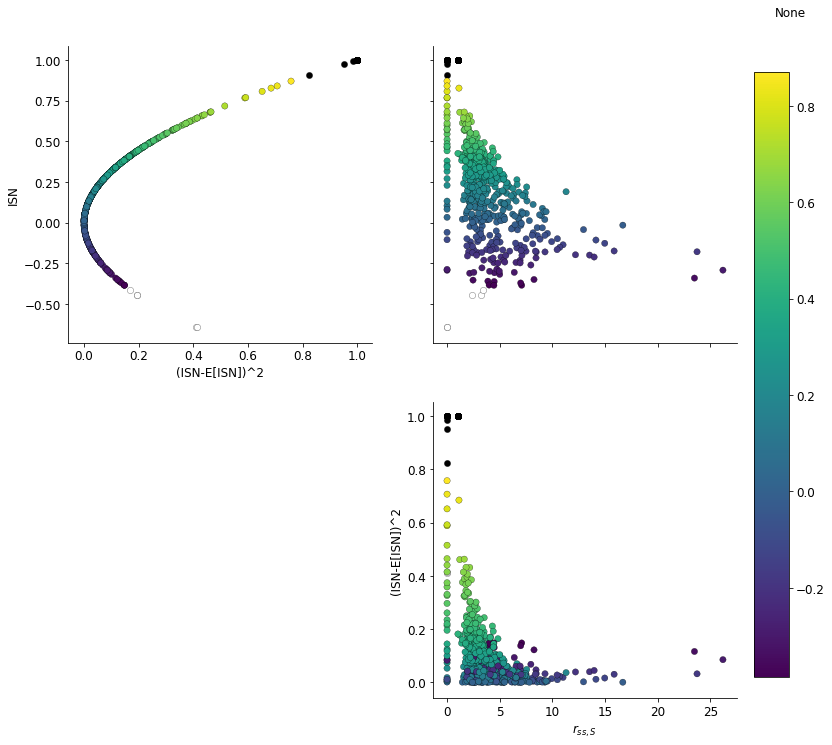

In [99]:
M = 1000
scale = 1.0*Z_v_low_std
_Z_v_low = np.random.normal(0.0, 1.0, (1,M,system.D))
_Z_v_low = (_Z_v_low * scale) + Z_v_low_mean
_T_x_v_low, _r_t_v_low = sess.run([T_x, r_t] , {Z:_Z_v_low});

drdt_T_v_low = _r_t_v_low[-1,0,:,:,0] - _r_t_v_low[-2,0,:,:,0]
drdt_th = 0.001
on_th = 0.01

stable_v_low = np.prod(np.abs(drdt_T_v_low) < drdt_th, axis=1).astype(bool)
print('num stable', np.sum(stable_v_low), M)

fig = pairplot(_Z_v_low[0,stable_v_low,:], range(8), system.z_labels, 
               c=_T_x_v_low[0,stable_v_low,0], xlims=[0.0, 20.0], ylims=[0.0, 20.0])

fig = pairplot(_T_x_v_low[0,stable_v_low], range(3), system.T_x_labels, 
               c=_T_x_v_low[0,stable_v_low,0])


In [98]:
mean_T_x_v_low = np.mean(_T_x_v_low[0], 0)
print(mean_T_x_v_low)

mean_T_x_v_low_stable = np.mean(_T_x_s_low[0,stable_v_low], 0)
print(mean_T_x_v_low_stable)

[0.0591631  0.00645526 4.07055848]
[-7.98135539e-02  1.26721367e-02  1.82492427e-11]
